# Graficación manual de una señal Chirp

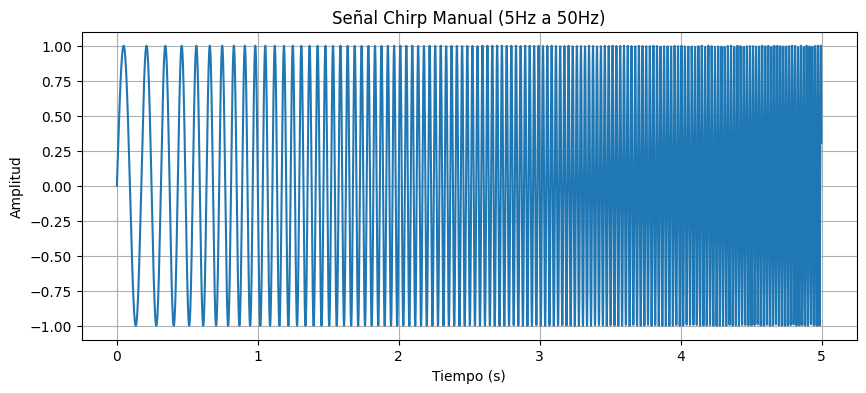

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
fs = 1000  # Frecuencia de muestreo
T = 5.0    # Duración
t = np.linspace(0, T, int(T * fs), endpoint=False)

f0 = 5     # Frecuencia inicial
f1 = 50    # Frecuencia final

# Crear chirp manualmente (frecuencia linealmente variable)
chirp_signal = np.sin(2 * np.pi * (f0 * t + (f1 - f0) * t**2 / (2 * T)))

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(t, chirp_signal)
plt.title('Señal Chirp Manual (5Hz a 50Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

# Graficación y cálculo de la FFT de un segmento de la señal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, get_window
from ipywidgets import interact, FloatSlider, Dropdown
import ipywidgets as widgets

# Configuración inicial
fs = 1000  # Frecuencia de muestreo (Hz)
T = 2.0    # Duración total (segundos)
t = np.linspace(0, T, int(T * fs), endpoint=False)
f0, f1 = 10, 100  # Frecuencias inicial y final

# Generar señal chirp
signal = chirp(t, f0=f0, f1=f1, t1=T, method='linear')

# Función para calcular FFT
def compute_fft(signal_segment, fs):
    n = len(signal_segment)
    freq = np.fft.rfftfreq(n, d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal_segment))
    return freq, fft_vals

# Función principal de visualización
def plot_chirp_with_window(window_position=1.0, window_width=0.2, window_type='hann'):
    plt.figure(figsize=(14, 8))
    
    # --- Gráfico superior: Señal temporal con ventana ---
    plt.subplot(2, 1, 1)
    plt.plot(t, signal, label='Señal Chirp')
    
    # Calcular límites de la ventana
    win_start = max(0, window_position - window_width/2)
    win_end = min(T, window_position + window_width/2)
    
    # Resaltar la región de la ventana
    mask = (t >= win_start) & (t <= win_end)
    plt.fill_between(t, -1, 1, where=mask, color='orange', alpha=0.3, label='Ventana')
    plt.plot(t[mask], signal[mask], 'r-', linewidth=1.5, label='Señal en ventana')
    
    plt.title(f'Señal Chirp con Ventana ({window_type})')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.ylim(-1.1, 1.1)
    plt.grid(True)
    plt.legend()
    
    # --- Gráfico inferior: FFT de la ventana ---
    plt.subplot(2, 1, 2)
    
    # Extraer segmento y aplicar ventana
    segment = signal[mask]
    if len(segment) > 0:  # Asegurarse que hay datos en la ventana
        window = get_window(window_type, len(segment))
        windowed_segment = segment * window
        
        # Calcular FFT
        freq, fft_vals = compute_fft(windowed_segment, fs)
        
        # Graficar FFT
        plt.plot(freq, fft_vals, 'b-', label='FFT')
        plt.title('Espectro de Frecuencia (FFT) de la región seleccionada')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Magnitud')
        plt.grid(True)
        plt.xlim(0, 150)
    else:
        plt.text(0.5, 0.5, 'No hay datos en la ventana seleccionada', 
                ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

# Crear widgets
window_pos_slider = FloatSlider(value=1.0, min=0, max=T, step=0.01, description='Posición:')
window_width_slider = FloatSlider(value=0.2, min=0.01, max=1.0, step=0.01, description='Ancho:')
window_type_dropdown = Dropdown(
    options=['boxcar', 'hann', 'hamming', 'blackman', 'bartlett'],
    value='hann',
    description='Tipo de ventana:'
)

# Mostrar la interfaz interactiva
interact(plot_chirp_with_window, 
         window_position=window_pos_slider,
         window_width=window_width_slider,
         window_type=window_type_dropdown);

interactive(children=(FloatSlider(value=1.0, description='Posición:', max=2.0, step=0.01), FloatSlider(value=0…